## Import libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import spacy
from cleantext import clean
import re
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, precision_score, f1_score, roc_auc_score, auc, confusion_matrix, classification_report, roc_curve 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, TextVectorization, Embedding, LSTM, GRU, Dense, Dropout
import joblib

In [2]:
nlp = spacy.load('en_core_web_sm')

## Import data

In [3]:
data_1 = pd.read_csv("./movie_reviews/train.csv")
data_2 = pd.read_csv("./movie_reviews/test.csv")

In [4]:
print(f"Data_1 shape: {data_1.shape}")
print(f"Data_2 shape: {data_2.shape}")

Data_1 shape: (25000, 2)
Data_2 shape: (25000, 2)


## Data preprocessing

- In the dataset, two separate `.csv` files are provided, named => `'train.csv'` and `'test.csv'`.
- Although, it is not a good train-test split, so combining them and then splitting will be a good idea

In [5]:
data_1.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [6]:
data_2.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [7]:
data = pd.concat(objs = [data_1, data_2], axis = 0, ignore_index = True)
data.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [8]:
data['sentiment'].value_counts()

sentiment
neg    25000
pos    25000
Name: count, dtype: int64

- A perfect 50-50 split of labels

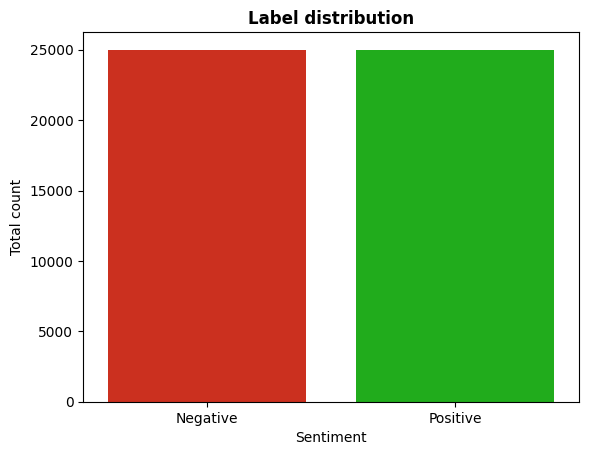

In [9]:
sns.countplot(x = data['sentiment'], palette = ['#e81902', '#0ac404'])
plt.xlabel("Sentiment")
plt.ylabel("Total count")
plt.xticks((0, 1), ("Negative", "Positive"))
plt.title("Label distribution", fontweight='bold');

- Text cleaning & preprocessing

In [10]:
# def clean_text(text):
#     text = clean(text, lower = True, no_line_breaks = True, no_urls = True, no_emails = True, 
#                  no_phone_numbers = True, no_numbers = True, no_currency_symbols = True, no_punct = True,
#                  no_emoji = True, no_digits = True, replace_with_currency_symbol = "", replace_with_url = "",
#                  replace_with_email = "", replace_with_number = "", replace_with_digit = "")
#     doc = nlp(text)
#     text = [token.lemma_ for token in doc if token.lemma_ != "I" and not token.is_stop]
#     return " ".join(text)

In [11]:
# tqdm.pandas()

# cleaned_text = data['text'].progress_apply(clean_text)

In [12]:
# cleaned_text = cleaned_text.str.strip()
# cleaned_text.head()

- Remove duplicates

In [13]:
# cleaned_text.duplicated().sum()

In [14]:
# cleaned_text = cleaned_text.drop_duplicates(keep = 'first')

In [15]:
# cleaned_text.shape

- Save only the remaining data

In [16]:
# data_new = data.iloc[cleaned_text.index].copy()
# data_new['text'] = cleaned_text

In [17]:
# data_new

In [18]:
# data_new.isna().sum()

In [19]:
# data_new.duplicated().sum()

Now, to avoid cleaning the text again, saving the new dataframe to a `'.csv'` file

In [20]:
# data_new.to_csv('cleaned_data.csv', index=False)

### Cleaned data

In [2]:
data = pd.read_csv('cleaned_data.csv')
data.head()

,text,sentiment
0,will not deny purchase ebay high expectation i...,neg
1,sad thing tribute singer include incredibly ta...,neg
2,night decide watch prequel shall call prequel ...,neg
3,admit like half sleeper look good acting well ...,neg
4,impressed film especially fact go cinema famil...,neg


### Label encoding the sentiment labels

In [3]:
data['sentiment'] = data['sentiment'].map({
    'neg': 0,
    'pos': 1
})

In [4]:
data.head()

,text,sentiment
0,will not deny purchase ebay high expectation i...,0
1,sad thing tribute singer include incredibly ta...,0
2,night decide watch prequel shall call prequel ...,0
3,admit like half sleeper look good acting well ...,0
4,impressed film especially fact go cinema famil...,0


- Just observed there are some html tags present in the texts, removing it

In [5]:
remove_html_tags = lambda x: re.sub(string = x, pattern="<\s*[\S+]+\s*>", repl = "")
data['text'] = data['text'].apply(remove_html_tags)

In [6]:
data['text'] = data['text'].str.strip()
data['text'].duplicated().sum()

1

In [7]:
data = data.drop_duplicates(keep = 'first')

In [8]:
data.sample(5)

,text,sentiment
297,east palace west palace remind somewhat detect...,0
20320,finale weissmull tarzan movie weak thing derai...,0
34014,mullholland drive prove david lynch master cin...,1
36851,kick new fan excellenttheir entitle opinion ne...,1
26783,movie historical document display talent black...,1


### Generating Wordcloud

- Neagtive words

In [28]:
neg_texts = data[data['sentiment'] == 0]['text'].to_numpy()   # Selecting only the negative data
neg_words = " ".join(neg_texts)    # Creating a long sentence of negative comments
neg_words[:200]  

'will not deny purchase ebay high expectation incredible outofprint work master comedy enjoy soon disappoint apology enjoy find compleat al difficult watch get smile sure majority funny come music vide'

Text(0.5, 1.0, 'Negative WordCloud')

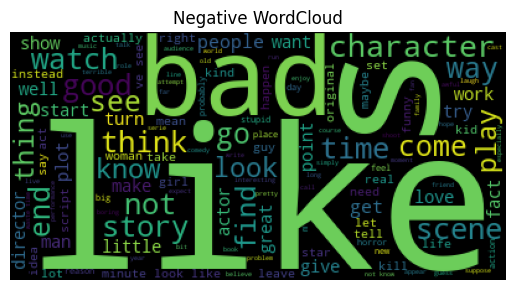

In [29]:
neg_wordcloud = WordCloud(stopwords = ['film', 'movie']).generate(text = neg_words)
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.title("Negative WordCloud")

- Positive words

In [30]:
pos_texts = data[data['sentiment'] == 1]['text'].to_numpy()   # Selecting only the positive data
pos_words = " ".join(pos_texts)    # Creating a long sentence of positive comments
pos_words[:200]  

'original movie odd couple wonderful comic oneliner entire world know story neurotic neatfreak felix ungar funny obnoxious slob oscar madison paring mismatched roommate create successful tv series time'

Text(0.5, 1.0, 'Positive WordCloud')

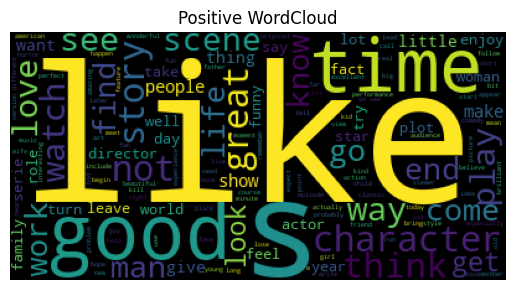

In [31]:
pos_wordcloud = WordCloud(stopwords = ['film', 'movie']).generate(text = pos_words)
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.title("Positive WordCloud")

## Modelling experiments

### Train-test split

In [9]:
X = data['text'].to_numpy()
y = data['sentiment'].to_numpy()

X.shape, y.shape

((49576,), (49576,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37182,), (37182,), (12394,), (12394,))

### Function to evaulate model performance

In [112]:
def model_performace(y_test, y_pred):
    return {
        'accuracy': np.round(accuracy_score(y_test, y_pred), 3),
        'recall': np.round(recall_score(y_test, y_pred), 3),
        'precision': np.round(precision_score(y_test, y_pred), 3),
        'f1_score': np.round(f1_score(y_test, y_pred), 3)
    }

### Feature extraction using `TfidfVectorizer`

In [12]:
tfidf = TfidfVectorizer(max_df = 0.8, min_df = 5)
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)    # It is very important to note that for the test set, the train set tfidf model is used

In [13]:
print(f"Total number of words: {len(tfidf.get_feature_names_out())}")

Total number of words: 26716


### **RandomForest** classifier

In [37]:
%%time
rdf = RandomForestClassifier(random_state = 1, n_jobs = -1)
rdf.fit(X_train_tfidf, y_train)

y_pred_rdf = rdf.predict(X_test_tfidf)


CPU times: total: 4min 46s
Wall time: 27.3 s


In [38]:
model_performace(y_test, y_pred_rdf)

{'accuracy': 0.849, 'recall': 0.845, 'precision': 0.854, 'f1_score': 0.849}

#### **LightGBM** classifier

In [40]:
%%time
lgbm = LGBMClassifier(random_state = 1)
lgbm.fit(X_train_tfidf, y_train)

y_pred_lgbm = lgbm.predict(X_test_tfidf)

model_performace(y_test, y_pred_lgbm)


[LightGBM] [Info] Number of positive: 18657, number of negative: 18525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.896883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 591011
[LightGBM] [Info] Number of data points in the train set: 37182, number of used features: 11903
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501775 -> initscore=0.007100
[LightGBM] [Info] Start training from score 0.007100
CPU times: total: 56.8 s
Wall time: 16.5 s


{'accuracy': 0.857, 'recall': 0.872, 'precision': 0.847, 'f1_score': 0.86}

#### **XGBM** classifier

In [41]:
%%time
xgb = XGBClassifier(random_state = 1)
xgb.fit(X_train_tfidf, y_train)

y_pred_xgb = xgb.predict(X_test_tfidf)

model_performace(y_test, y_pred_xgb)


CPU times: total: 2min 3s
Wall time: 30.1 s


{'accuracy': 0.85, 'recall': 0.872, 'precision': 0.837, 'f1_score': 0.854}

#### **CatBoost** classifier

In [42]:
%%time
ctb = CatBoostClassifier(random_state = 1)
ctb.fit(X_train_tfidf, y_train)

y_pred_ctb = ctb.predict(X_test_tfidf)

model_performace(y_test, y_pred_ctb)


Learning rate set to 0.048247
0:	learn: 0.6784451	total: 874ms	remaining: 14m 32s
1:	learn: 0.6651177	total: 1.44s	remaining: 11m 58s
2:	learn: 0.6526376	total: 1.99s	remaining: 11m 2s
3:	learn: 0.6417183	total: 2.58s	remaining: 10m 43s
4:	learn: 0.6317737	total: 3.2s	remaining: 10m 36s
5:	learn: 0.6224779	total: 3.78s	remaining: 10m 26s
6:	learn: 0.6144084	total: 4.39s	remaining: 10m 23s
7:	learn: 0.6071442	total: 4.92s	remaining: 10m 9s
8:	learn: 0.6001401	total: 5.43s	remaining: 9m 58s
9:	learn: 0.5941583	total: 5.92s	remaining: 9m 46s
10:	learn: 0.5881080	total: 6.4s	remaining: 9m 35s
11:	learn: 0.5827609	total: 6.88s	remaining: 9m 26s
12:	learn: 0.5776621	total: 7.35s	remaining: 9m 18s
13:	learn: 0.5728849	total: 7.83s	remaining: 9m 11s
14:	learn: 0.5688721	total: 8.28s	remaining: 9m 3s
15:	learn: 0.5645819	total: 8.77s	remaining: 8m 59s
16:	learn: 0.5609954	total: 9.28s	remaining: 8m 56s
17:	learn: 0.5574383	total: 9.77s	remaining: 8m 53s
18:	learn: 0.5540424	total: 10.3s	remaini

{'accuracy': 0.867, 'recall': 0.89, 'precision': 0.851, 'f1_score': 0.87}

##### So far, the `CatBoost` model is the best performing model!
- Let's dig deeper!

- What are the most important 5 words that was considered by CatBoost to classify the comments?

In [58]:
top_5_word_indices = np.argsort(ctb.feature_importances_)[-5:]

In [59]:
tfidf.get_feature_names_out()[top_5_word_indices]

array(['excellent', 'awful', 'great', 'waste', 'bad'], dtype=object)

- Save the model

In [60]:
joblib.dump(ctb, "./saved_models/catboost_model.pkl")

['catboost_model.pkl']

- Load the model

In [14]:
ctb = joblib.load("./save_models/catboost_model.pkl")
y_pred_ctb = ctb.predict(X_test_tfidf)

In [15]:
roc_auc_score_ctb = roc_auc_score(y_test, y_pred_ctb)
print(f"Area under the curve of the ROC curve: {roc_auc_score_ctb:.3f}")

Area under the curve of the ROC curve: 0.866


- Plot ROC_AUC curve

In [16]:
y_proba_pos = ctb.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, y_proba_pos)

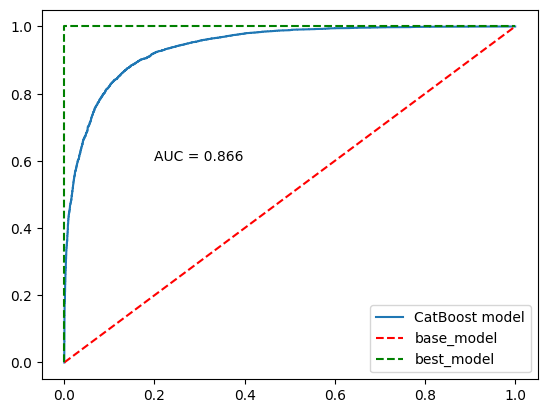

In [96]:
plt.plot(fpr, tpr, label = 'CatBoost model')
plt.plot([0, 1], [0, 1], 'r--', label = 'base_model')
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label = 'best_model')
plt.text(x = 0.2, y = 0.6, s = f"AUC = {roc_auc_score_ctb:.3f}")
plt.legend();

- Classification report

In [98]:
print(classification_report(y_test, y_pred_ctb))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      6170
           1       0.85      0.89      0.87      6224

    accuracy                           0.87     12394
   macro avg       0.87      0.87      0.87     12394
weighted avg       0.87      0.87      0.87     12394



- Confusion Matrix

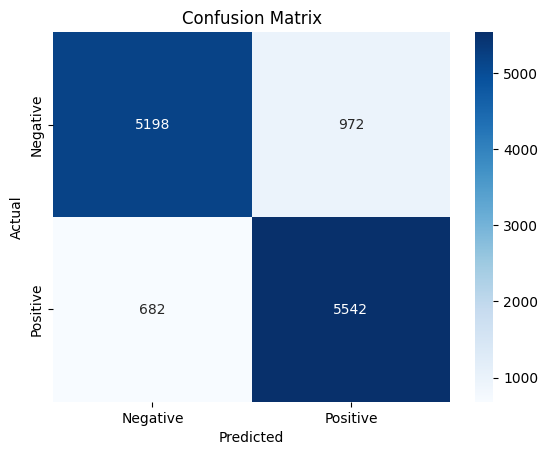

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred_ctb), annot=True, fmt = 'd', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks((0.5, 1.5), ("Negative", "Positive"))
plt.yticks((0.5, 1.5), ("Negative", "Positive"));
plt.title("Confusion Matrix");

## **Deep Learning** models

In [91]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath = f"./saved_models/{model_name}.keras",
        monitor = 'val_accuracy',
        save_best_only = True,
        verbose = 1
    )

In [92]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 1)

#### **LSTM**

##### Text Vectorization layer

- Let's find the output sequence length by observing what is the max length of most of the observations

In [42]:
len_of_texts = [len(text.split()) for text in X_train]

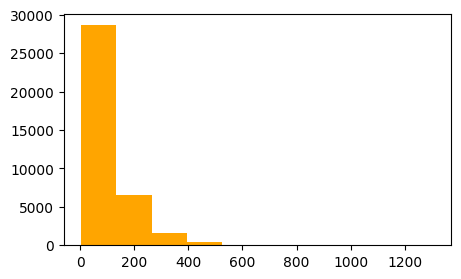

In [43]:
plt.figure(figsize = (5, 3))
plt.hist(len_of_texts, color = 'orange');

In [51]:
max_len = np.percentile(len_of_texts, 95)
print(f"95% of the train texts has length: {int(max_len)}")

95% of the train texts has length: 271


- Define the TextVectorization layer

In [72]:
max_tokens = 10_000
text_vect = TextVectorization(max_tokens = max_tokens, output_mode = 'int', output_sequence_length = 250)
text_vect.adapt(X_train);

##### Word Embedding layer

In [73]:
vocab_size = len(text_vect.get_vocabulary())
word_embed = Embedding(input_dim = vocab_size, input_length = 250, output_dim = 256, mask_zero = True)

- LSTM architecture

In [96]:
inputs = Input(shape = (1,), dtype = tf.string)
x = text_vect(inputs)
x = word_embed(x)
x = LSTM(units = 128)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
outputs = Dense(units = 1, activation = 'sigmoid')(x)

lstm_model = Model(inputs=inputs, outputs=outputs)

In [97]:
lstm_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 250)               0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 250, 256)          2560000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                           

In [98]:
lstm_model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [99]:
model_hist = lstm_model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = 32, callbacks = [model_ckpt("lstm_model_2"), early_stop])

Epoch 1/5
1162/1162 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9424
Epoch 1: val_accuracy improved from -inf to 0.84807, saving model to ./saved_models\lstm_model_2.keras
1162/1162 [==============================] - 214s 181ms/step - loss: 0.1608 - accuracy: 0.9424 - val_loss: 0.4360 - val_accuracy: 0.8481
Epoch 2/5
1162/1162 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9735
Epoch 2: val_accuracy improved from 0.84807 to 0.84936, saving model to ./saved_models\lstm_model_2.keras
1162/1162 [==============================] - 204s 176ms/step - loss: 0.0774 - accuracy: 0.9735 - val_loss: 0.4927 - val_accuracy: 0.8494
Epoch 3/5
1162/1162 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9816
Epoch 3: val_accuracy improved from 0.84936 to 0.86251, saving model to ./saved_models\lstm_model_2.keras
1162/1162 [==============================] - 200s 172ms/step - loss: 0.0576 - accuracy: 0.9816 - val_loss: 0.6315 - val_

In [103]:
loaded_model = tf.keras.models.load_model("saved_models/lstm_model.keras")
loaded_model.evaluate(X_test, y_test)

388/388 [==============================] - 22s 52ms/step - loss: 0.2981 - accuracy: 0.8793


[0.2981186807155609, 0.8792964220046997]

#### We have found our `BEST MODEL` YET!!

- Evaluate LSTM model performance

In [104]:
y_pred_lstm = loaded_model.predict(X_test)

388/388 [==============================] - 22s 54ms/step


In [113]:
y_pred = np.squeeze(np.round(y_pred_lstm))
model_performace(y_test, y_pred)

{'accuracy': 0.879, 'recall': 0.912, 'precision': 0.857, 'f1_score': 0.884}

- Classification Report

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      6170
           1       0.86      0.91      0.88      6224

    accuracy                           0.88     12394
   macro avg       0.88      0.88      0.88     12394
weighted avg       0.88      0.88      0.88     12394



- ROC_AUC Score

In [116]:
roc_auc_score_lstm = roc_auc_score(y_test, y_pred)
print(f"Area under the curve of the ROC curve: {roc_auc_score_lstm:.3f}")

Area under the curve of the ROC curve: 0.879


- Plot ROC curve

In [117]:
fpr, tpr, thresh = roc_curve(y_test, y_pred_lstm)

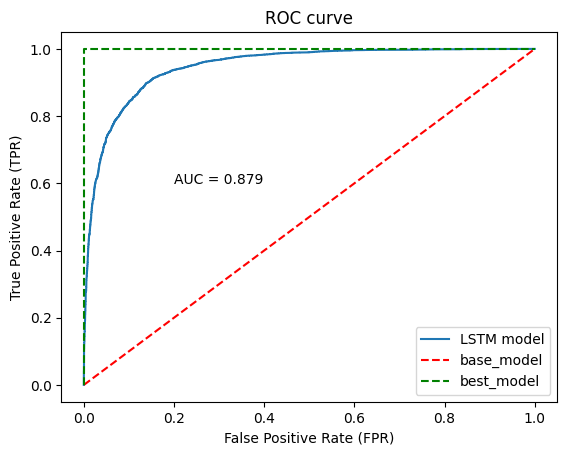

In [120]:
plt.plot(fpr, tpr, label = 'LSTM model')
plt.plot([0, 1], [0, 1], 'r--', label = 'base_model')
plt.plot([0, 0, 1], [0, 1, 1], 'g--', label = 'best_model')
plt.text(x = 0.2, y = 0.6, s = f"AUC = {roc_auc_score_lstm:.3f}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC curve")
plt.legend();

- Precision Recall curve

In [121]:
recall, precision, _ = precision_recall_curve(y_test, y_pred_lstm)

In [136]:
auc_pr_curve = auc(precision, recall)
print(f"Area under the Precision-Recall curve: {auc_pr_curve:.3f}")

Area under the Precision-Recall curve: 0.944


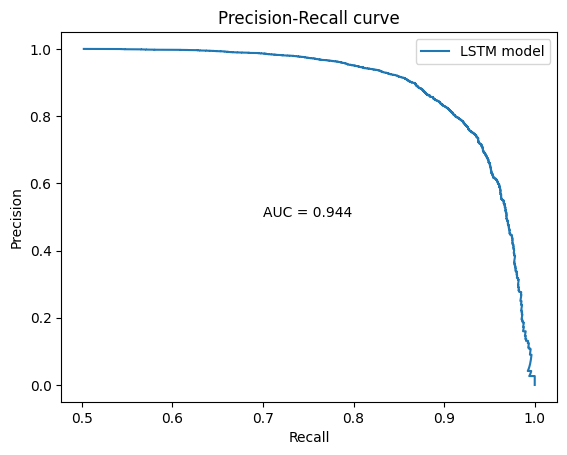

In [137]:
plt.plot(recall, precision, label = 'LSTM model')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.text(x = 0.7, y = 0.5, s = f"AUC = {auc_pr_curve:.3f}")
plt.legend();

- Confusion Matrix

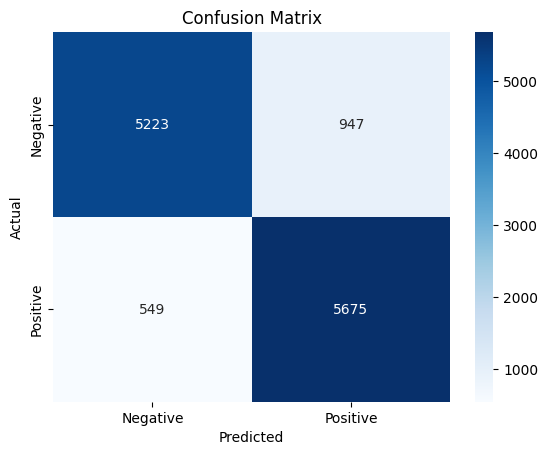

In [138]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'd', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks((0.5, 1.5), ("Negative", "Positive"))
plt.yticks((0.5, 1.5), ("Negative", "Positive"));
plt.title("Confusion Matrix");

### **Conclusion**
- `LSTM` model performs better with an accuracy of `~88%`
- Try adding more LSTM layer
- Try using other RNN models (GRU, BidirectionalLSTM) to find whether the model performance improves